In [25]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [189]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import datetime as dt
from sklearn.metrics import mean_squared_error

<ipython-input-189-efd8711adf57>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [190]:
import pandas as pd
#import datasets
plant_1 = pd.read_csv("Plant_1_Generation_data.csv")
plant_2 = pd.read_csv("Plant_2_Generation_data.csv")
weather_1 = pd.read_csv("Plant_1_Weather_Sensor_data.csv")
weather_2 = pd.read_csv("Plant_2_Weather_Sensor_data.csv")

## Data Exploration
our dataset consist of 4 files 2 for each plant
- power generation data
- weather sensor data

### The power generations data consists of 7 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | DC_POWER | AC_POWER | DAILY_YIELD | TOTAL_YIELD |
| --------- | -------- | ---------- | -------- | -------- | ----------- | ----------- |
| Date and time for each observation (%d-%m-%Y %H:%M). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Source key in this file stands for the inverter id. | Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. | Daily yield is a cumulative sum of power generated on that day till that point in time. | This is the total yield for the inverter till that point in time. |

### The weather data consists of 6 fields:
| DATE_TIME | PLANT_ID | SOURCE_KEY | AMBIENT_TEMPERATURE | MODULE_TEMPERATURE | IRRADIATION |
| --------- | -------- | ---------- | -------- | -------- | ----------- |
| Date and time for each observation (%d-%m-%Y %H:%M). Observations recorded at 15 minute intervals. | Plant ID - this will be common for the entire file. | Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. | This is the ambient temperature at the plant. | There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. | Amount of irradiation for the 15 minute interval. Solar irradiation is the quantity that measures the energy per unit area of ​​incident solar radiation on a surface - the power received during a time (J/m2 or Wh/m2 )  |

Data is gathered every 15 minutes for 34 days.

Expecting 3264 samples per sampling point:

24 hours x 4 times per hour x 34 days = 3264 samples

# Persistance Model

In [259]:
#Formatedattime

import datetime as dt
plant_1['DATE_TIME']= pd.to_datetime(plant_1['DATE_TIME'],format='%d-%m-%Y %H:%M')
weather_1['DATE_TIME']= pd.to_datetime(weather_1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
plant_1.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [260]:
# drop unwanted columns. 
df_weather_1 = weather_1.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_plant_1 = plant_1.drop(['PLANT_ID'], axis=1)

In [261]:
df_plant_weather_1 = df_plant_1.merge(df_weather_1, on="DATE_TIME")
print(df_plant_weather_1.head)


<bound method NDFrame.head of                 DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0     2020-05-15 00:00:00  1BY6WEcLGh8j5v7       0.0       0.0        0.000   
1     2020-05-15 00:00:00  1IF53ai7Xc0U56Y       0.0       0.0        0.000   
2     2020-05-15 00:00:00  3PZuoBAID5Wc2HD       0.0       0.0        0.000   
3     2020-05-15 00:00:00  7JYdWkrLSPkdwr4       0.0       0.0        0.000   
4     2020-05-15 00:00:00  McdE0feGgRqW7Ca       0.0       0.0        0.000   
...                   ...              ...       ...       ...          ...   
68769 2020-06-17 23:45:00  uHbuxQJl8lW7ozc       0.0       0.0     5967.000   
68770 2020-06-17 23:45:00  wCURE6d3bPkepu2       0.0       0.0     5147.625   
68771 2020-06-17 23:45:00  z9Y9gH1T5YWrNuG       0.0       0.0     5819.000   
68772 2020-06-17 23:45:00  zBIq5rxdHJRwDNY       0.0       0.0     5817.000   
68773 2020-06-17 23:45:00  zVJPv84UY57bAof       0.0       0.0     5910.000   

       TOTAL_YIELD  A

In [292]:
if df_plant_weather_1.index.name != 'DATE_TIME':
    df_plant_weather_1.set_index('DATE_TIME', inplace=True)

#print(df_plant_weather_1.head())

locate_hour = df_plant_weather_1.index.indexer_at_time('16:00:00')
df_plant_weather_1.iloc[locate_hour]



,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,,
2020-05-15 16:00:00,1BY6WEcLGh8j5v7,4551.142857,446.571429,5275.285714,6264834.286,34.381150,43.332853,0.358182
2020-05-15 16:00:00,1IF53ai7Xc0U56Y,4834.625000,474.287500,5844.625000,6189489.625,34.381150,43.332853,0.358182
2020-05-15 16:00:00,3PZuoBAID5Wc2HD,4791.875000,470.112500,5770.875000,6993529.875,34.381150,43.332853,0.358182
2020-05-15 16:00:00,7JYdWkrLSPkdwr4,4853.000000,476.087500,5608.000000,7608568.000,34.381150,43.332853,0.358182
2020-05-15 16:00:00,McdE0feGgRqW7Ca,5144.250000,504.537500,5924.500000,7164888.500,34.381150,43.332853,0.358182
...,...,...,...,...,...,...,...,...
2020-06-17 16:00:00,uHbuxQJl8lW7ozc,3243.142857,318.642857,5607.285714,7286642.286,23.403528,24.986668,0.199771
2020-06-17 16:00:00,wCURE6d3bPkepu2,3101.714286,304.771429,5524.857143,7028242.857,23.403528,24.986668,0.199771
2020-06-17 16:00:00,z9Y9gH1T5YWrNuG,3040.000000,298.700000,5463.285714,7250848.286,23.403528,24.986668,0.199771


In [275]:
# Create lagged dataset, DATE_TIME and DC_POWER
values = pd.DataFrame(plant_1)[['DATE_TIME', 'DC_POWER']]
#print(values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 'DC_POWER_t-1', 't', 'DC_POWER_t']
print(dataframe)


                      t-1  DC_POWER_t-1                   t  DC_POWER_t
0                     NaT           NaN 2020-05-15 00:00:00         0.0
1     2020-05-15 00:00:00           0.0 2020-05-15 00:00:00         0.0
2     2020-05-15 00:00:00           0.0 2020-05-15 00:00:00         0.0
3     2020-05-15 00:00:00           0.0 2020-05-15 00:00:00         0.0
4     2020-05-15 00:00:00           0.0 2020-05-15 00:00:00         0.0
...                   ...           ...                 ...         ...
68773 2020-06-17 23:45:00           0.0 2020-06-17 23:45:00         0.0
68774 2020-06-17 23:45:00           0.0 2020-06-17 23:45:00         0.0
68775 2020-06-17 23:45:00           0.0 2020-06-17 23:45:00         0.0
68776 2020-06-17 23:45:00           0.0 2020-06-17 23:45:00         0.0
68777 2020-06-17 23:45:00           0.0 2020-06-17 23:45:00         0.0

[68778 rows x 4 columns]


In [ ]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets using TimeSeriesSplit, 80% training, 20% testing
n_splits = 2

X_train, X_test, y_train, y_test = train_test_split(new.index, new, test_size=0.2, random_state=42)

In [258]:
# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]



#X = dataframe.values
#train_size = int(len(X) * 0.80)
#train, test = X[1:train_size], X[train_size:]
#train_X, train_y = train[:,0], train[:,1]
#test_X, test_y = test[:,0], test[:,1]

[[NaT nan Timestamp('2020-05-15 00:00:00') 0.0]
 [Timestamp('2020-05-15 00:00:00') 0.0 Timestamp('2020-05-15 00:00:00')
  0.0]
 [Timestamp('2020-05-15 00:00:00') 0.0 Timestamp('2020-05-15 00:00:00')
  0.0]
 ...
 [Timestamp('2020-06-17 23:45:00') 0.0 Timestamp('2020-06-17 23:45:00')
  0.0]
 [Timestamp('2020-06-17 23:45:00') 0.0 Timestamp('2020-06-17 23:45:00')
  0.0]
 [Timestamp('2020-06-17 23:45:00') 0.0 Timestamp('2020-06-17 23:45:00')
  0.0]]


In [256]:
# persistence model
def model_persistence(x):
	return x

In [262]:
# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

ValueError: Found input variables with inconsistent numbers of samples: [13756, 0]

TypeError: float() argument must be a string or a number, not 'Timestamp'

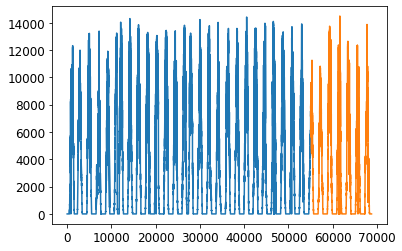

In [239]:
# plot predictions and expected results
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

In [156]:
df_plant_weather_1 = df_plant_1.merge(df_weather_1, on="DATE_TIME")
print(df_plant_weather_1)




                DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD  \
0     2020-05-15 00:00:00  1BY6WEcLGh8j5v7       0.0       0.0        0.000   
1     2020-05-15 00:00:00  1IF53ai7Xc0U56Y       0.0       0.0        0.000   
2     2020-05-15 00:00:00  3PZuoBAID5Wc2HD       0.0       0.0        0.000   
3     2020-05-15 00:00:00  7JYdWkrLSPkdwr4       0.0       0.0        0.000   
4     2020-05-15 00:00:00  McdE0feGgRqW7Ca       0.0       0.0        0.000   
...                   ...              ...       ...       ...          ...   
68769 2020-06-17 23:45:00  uHbuxQJl8lW7ozc       0.0       0.0     5967.000   
68770 2020-06-17 23:45:00  wCURE6d3bPkepu2       0.0       0.0     5147.625   
68771 2020-06-17 23:45:00  z9Y9gH1T5YWrNuG       0.0       0.0     5819.000   
68772 2020-06-17 23:45:00  zBIq5rxdHJRwDNY       0.0       0.0     5817.000   
68773 2020-06-17 23:45:00  zVJPv84UY57bAof       0.0       0.0     5910.000   

       TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEM

In [78]:
#mask_dato = pd.date_range(start='2020-05-15', end='2020-05-15)
#df_dates = (df_plant_weather_1.loc[mask_dato])


#time_between = df_dates.between_time('00:00:00', '00:04:00')
#time_between.
#mask = (df_plant_weather_1.[df_plant_weather_1.index].loc
#[pandas.Timestamp('2020-05-15 00:00:00'] > df_plant_weather_1[pandas.Timestamp('2020-05-15 00:04:00'])


In [149]:
from datetime import date, datetime, timedelta

def time_intervals(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta


for result in time_intervals(date(2020, 5, 15), date(2020, 5, 25), timedelta(days=4)):
    print(result)

#for result in time_intervals(date(2020, 5, 15),
#    date(2020, 5, 16),
#    timedelta(hours=4)):
#        print(result)



2020-05-15
2020-05-19
2020-05-23


In [158]:
hour_intervals = df_plant_weather_1.resample('4H').mean()
print(hour_intervals)



                        DC_POWER    AC_POWER  DAILY_YIELD   TOTAL_YIELD  \
DATE_TIME                                                                 
2020-05-15 00:00:00     0.000000    0.000000     0.000000  6.839251e+06   
2020-05-15 04:00:00   650.021102   63.596316    41.658461  6.847170e+06   
2020-05-15 08:00:00  6064.887365  593.892483  1303.149378  6.854105e+06   
2020-05-15 12:00:00  7758.648465  759.045562  4209.179759  6.857011e+06   
2020-05-15 16:00:00  1676.397593  164.351382  6130.682161  6.869361e+06   
...                          ...         ...          ...           ...   
2020-06-17 04:00:00   780.147263   76.532270    29.020350  7.091537e+06   
2020-06-17 08:00:00  6189.145749  606.256225  1266.078125  7.092774e+06   
2020-06-17 12:00:00  7235.344156  707.354616  4438.636414  7.095947e+06   
2020-06-17 16:00:00  1000.210278   97.785742  5805.118709  7.097313e+06   
2020-06-17 20:00:00     0.000000    0.000000  5885.022068  7.097398e+06   

                     AMB

### Investigating DC_POWER output by differnt time intervals

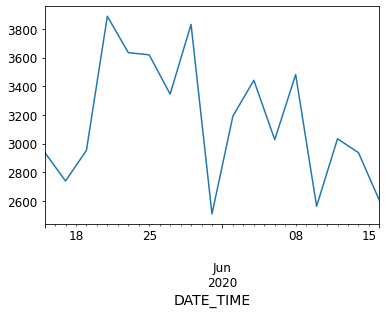

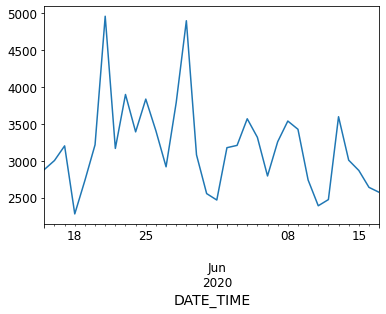

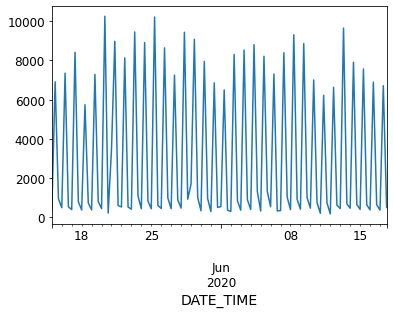

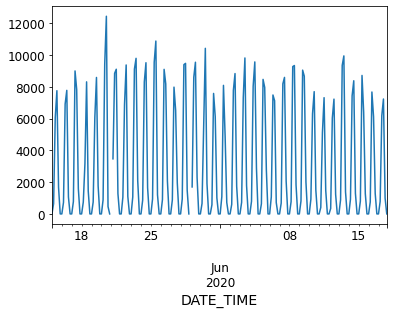

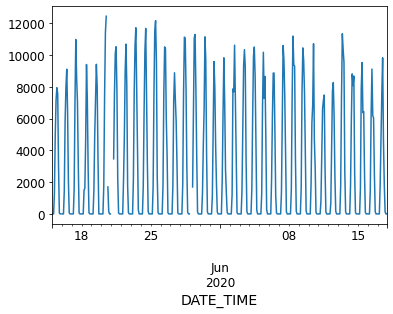

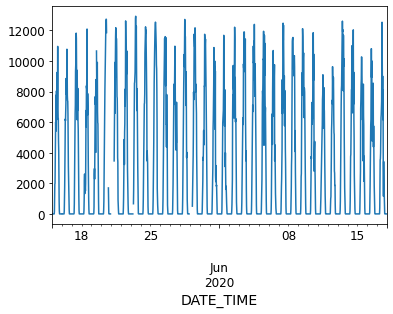

In [188]:

DC_POWER_per_2d = df_plant_weather_1.resample('2d').mean()
DC_POWER_per_2d = DC_POWER_per_2d['DC_POWER']

DC_POWER_per_2d.plot()
plt.show()


DC_POWER_per_24h = df_plant_weather_1.resample('24H').mean()
DC_POWER_per_24h = DC_POWER_per_24h['DC_POWER']

DC_POWER_per_24h.plot()
plt.show()

DC_POWER_per_8h = df_plant_weather_1.resample('8H').mean()
DC_POWER_per_8h = DC_POWER_per_8h['DC_POWER']

DC_POWER_per_8h.plot()
plt.show()

DC_POWER_per_4h = df_plant_weather_1.resample('4H').mean()
DC_POWER_per_4h = DC_POWER_per_4h['DC_POWER']

DC_POWER_per_4h.plot()
plt.show()

DC_POWER_per_2h = df_plant_weather_1.resample('2H').mean()
DC_POWER_per_2h = DC_POWER_per_2h['DC_POWER']

DC_POWER_per_2h.plot()
plt.show()

DC_POWER_per_30min = df_plant_weather_1.resample('30 min').mean()
DC_POWER_per_30min = DC_POWER_per_30min['DC_POWER']

DC_POWER_per_30min.plot()
plt.show()

# 


In [85]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error

def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')



AttributeError: 'numpy.ndarray' object has no attribute 'head'